# Computing the Maximum Lyapunov Exponent via displacement

We compare the MLE for standard training and robust training

In [168]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 58
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

58



# Data preparation

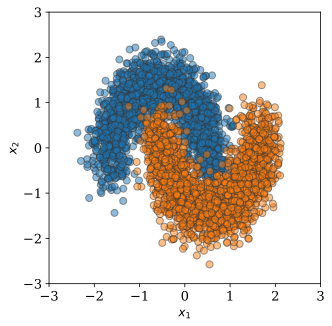

In [169]:
cross_entropy = False #this leads to squared loss in the training
data_noise = 0.2
batch_size = 5000
plotlim = [-3, 3]
subfolder = 'traj_moons'


if cross_entropy == True:
    label = 'scalar'
else: label = 'vector'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, batch_size = batch_size, plotlim = plotlim, random_state = seed, label = label)


## Model dynamics

In [170]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 10, 10
bound = 0.
fp = False #this recent change made things not work anymore
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'outside' #outside


## Training and generating level sets

In [171]:

num_epochs = 60 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [172]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/63
Loss: 2.196

Iteration 10/63
Loss: 2.310

Iteration 20/63
Loss: 2.365

Iteration 30/63
Loss: 2.072

Iteration 40/63
Loss: 2.082

Iteration 50/63
Loss: 2.156

Iteration 60/63
Loss: 2.012
Epoch 1: 2.184

Iteration 0/63
Loss: 2.067

Iteration 10/63
Loss: 2.109

Iteration 20/63
Loss: 2.085

Iteration 30/63
Loss: 2.031

Iteration 40/63
Loss: 2.002

Iteration 50/63
Loss: 1.995

Iteration 60/63
Loss: 1.951
Epoch 2: 2.031

Iteration 0/63
Loss: 1.997

Iteration 10/63
Loss: 1.939

Iteration 20/63
Loss: 1.913

Iteration 30/63
Loss: 1.864

Iteration 40/63
Loss: 1.888

Iteration 50/63
Loss: 1.879

Iteration 60/63
Loss: 1.844
Epoch 3: 1.916

Iteration 0/63
Loss: 1.725

Iteration 10/63
Loss: 1.805

Iteration 20/63
Loss: 1.747

Iteration 30/63
Loss: 1.815

Iteration 40/63
Loss: 1.853

Iteration 50/63
Loss: 1.706

Iteration 60/63
Loss: 1.604
Epoch 4: 1.663

Iteration 0/63
Loss: 1.371

Iteration 10/63
Loss: 1.411

Iteration 20/63
Loss: 1.110

Iteration 30/63
Loss: 1.305

Iteration 40/63


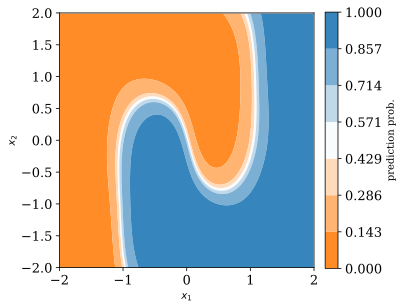

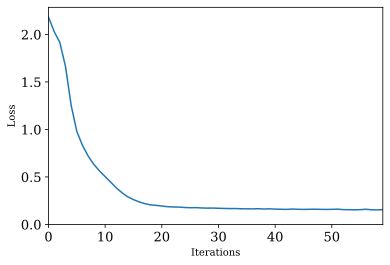

In [173]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

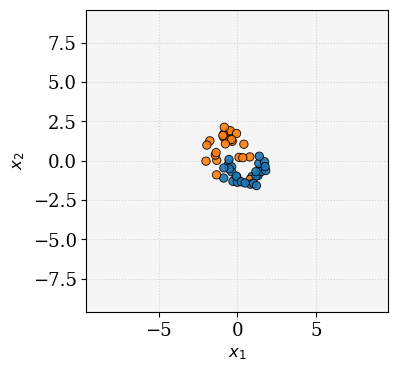

In [174]:
from plots.gifs import trajectory_gif
from IPython.display import Image

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
display(traj)

In [175]:
   
w = anode.linear_layer.weight
b = anode.linear_layer.bias

print(w)
print(b)

rnode.linear_layer.weight = w
rnode.linear_layer.bias = b

rnode.linear_layer.requires_grad =  False

Parameter containing:
tensor([[-0.1041,  0.0706],
        [-0.2038, -0.5549]], requires_grad=True)
Parameter containing:
tensor([-0.0372,  0.4243], requires_grad=True)


In [176]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type='l2') 
trainer_rnode.train(dataloader, num_epochs)


Iteration 0/63
Loss: 1.861

Iteration 10/63
Loss: 1.873

Iteration 20/63
Loss: 1.827

Iteration 30/63
Loss: 1.824

Iteration 40/63
Loss: 1.715

Iteration 50/63
Loss: 1.685

Iteration 60/63
Loss: 1.698
Epoch 1: 1.782

Iteration 0/63
Loss: 1.708

Iteration 10/63
Loss: 1.614

Iteration 20/63
Loss: 1.655

Iteration 30/63
Loss: 1.644

Iteration 40/63
Loss: 1.635

Iteration 50/63
Loss: 1.645

Iteration 60/63
Loss: 1.595
Epoch 2: 1.631

Iteration 0/63
Loss: 1.605

Iteration 10/63
Loss: 1.603

Iteration 20/63
Loss: 1.512

Iteration 30/63
Loss: 1.532

Iteration 40/63
Loss: 1.520

Iteration 50/63
Loss: 1.423

Iteration 60/63
Loss: 1.568
Epoch 3: 1.528

Iteration 0/63
Loss: 1.494

Iteration 10/63
Loss: 1.361

Iteration 20/63
Loss: 1.404

Iteration 30/63
Loss: 1.315

Iteration 40/63
Loss: 1.362

Iteration 50/63
Loss: 1.205

Iteration 60/63
Loss: 1.142
Epoch 4: 1.338

Iteration 0/63
Loss: 1.245

Iteration 10/63
Loss: 1.318

Iteration 20/63
Loss: 1.131

Iteration 30/63
Loss: 0.895

Iteration 40/63


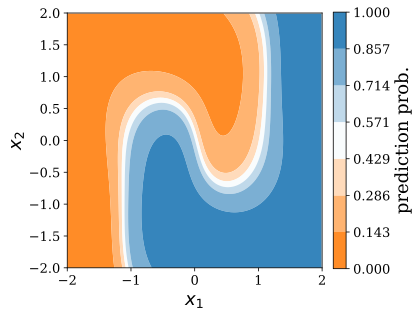

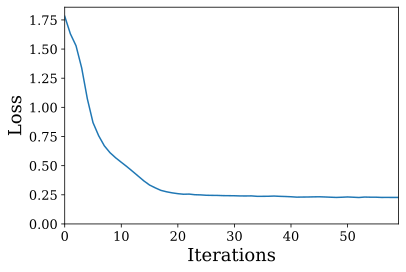

In [177]:
from plots.plots import classification_levelsets
classification_levelsets(rnode)
plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

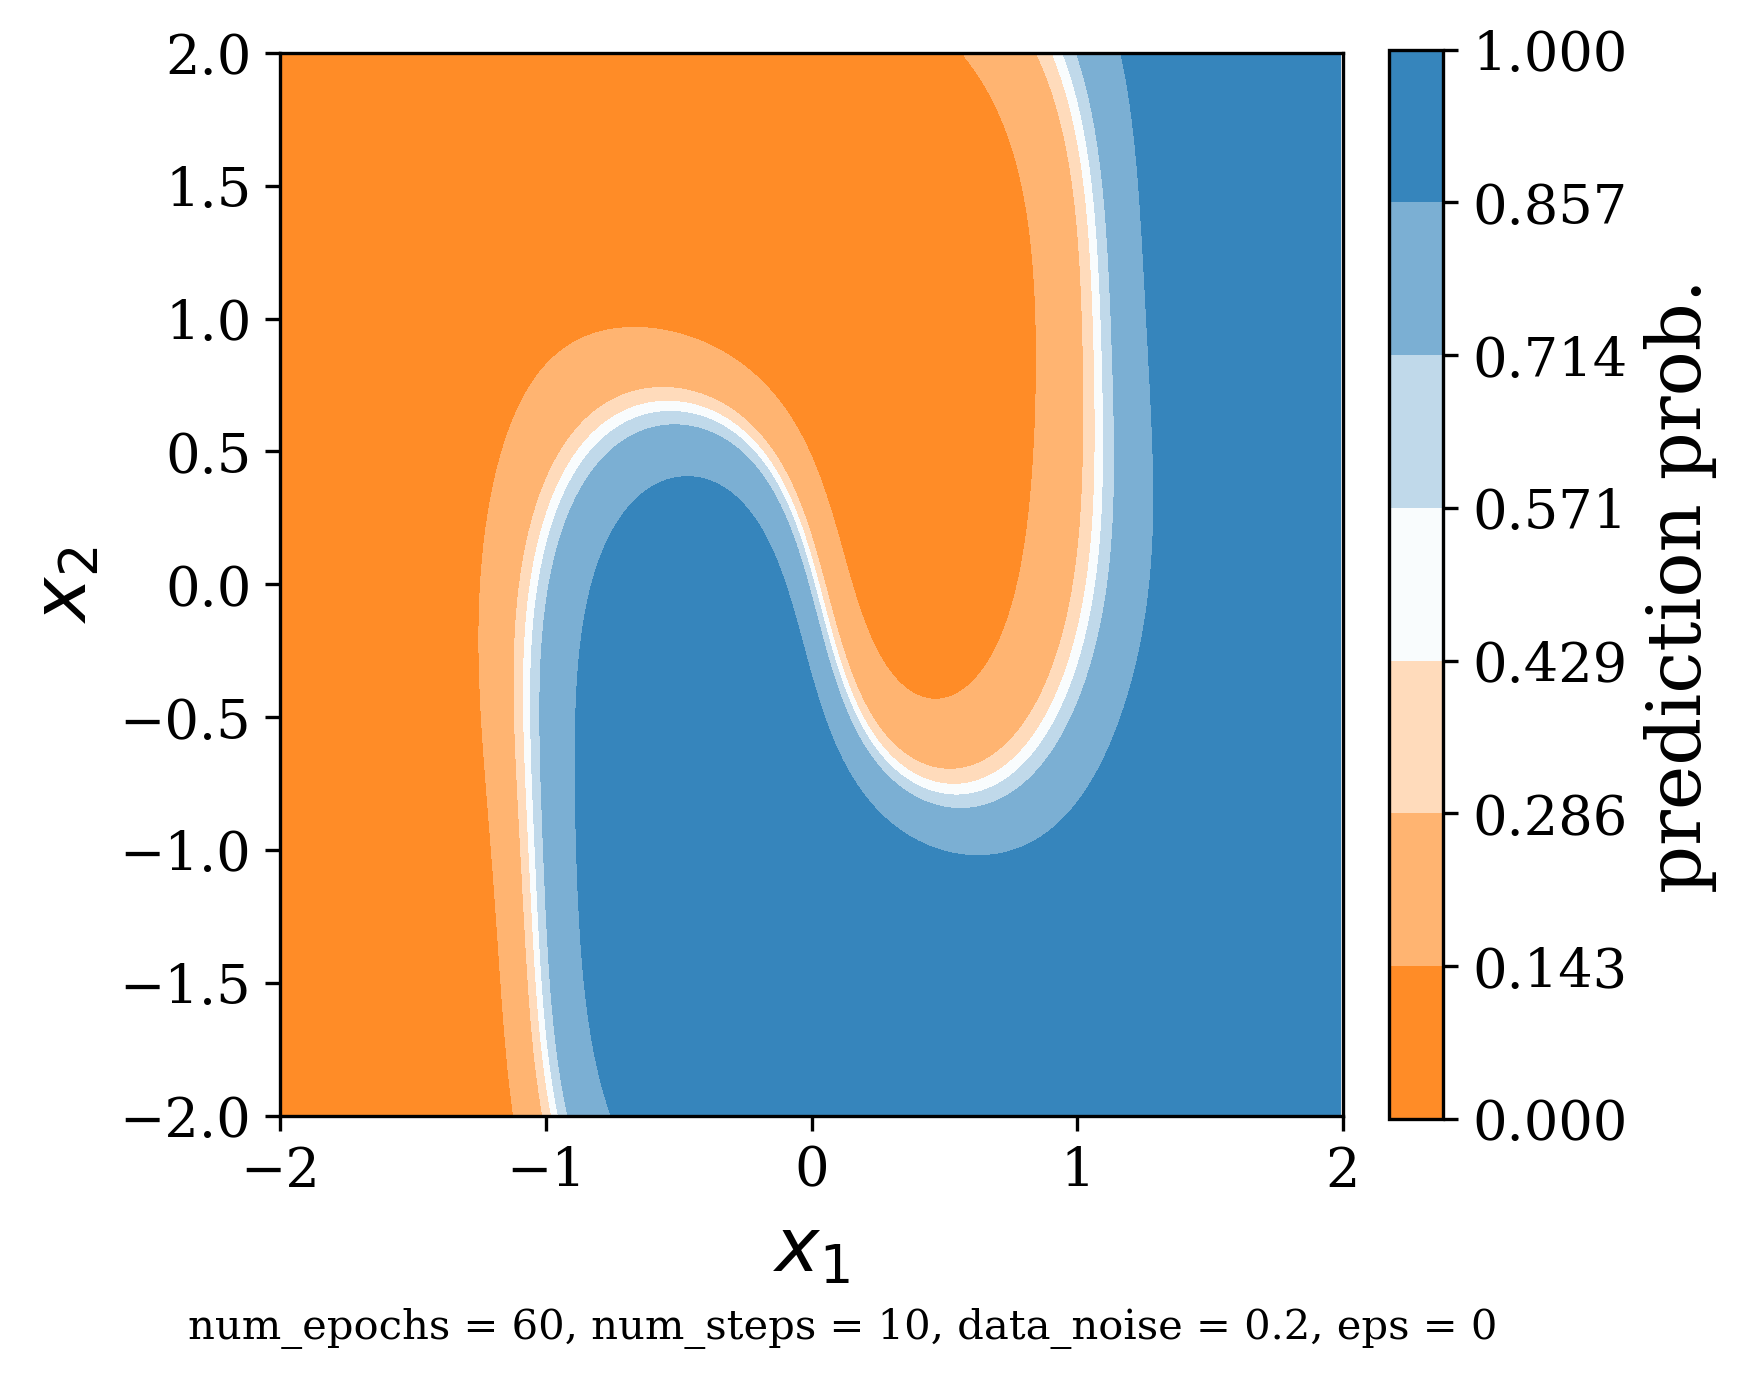

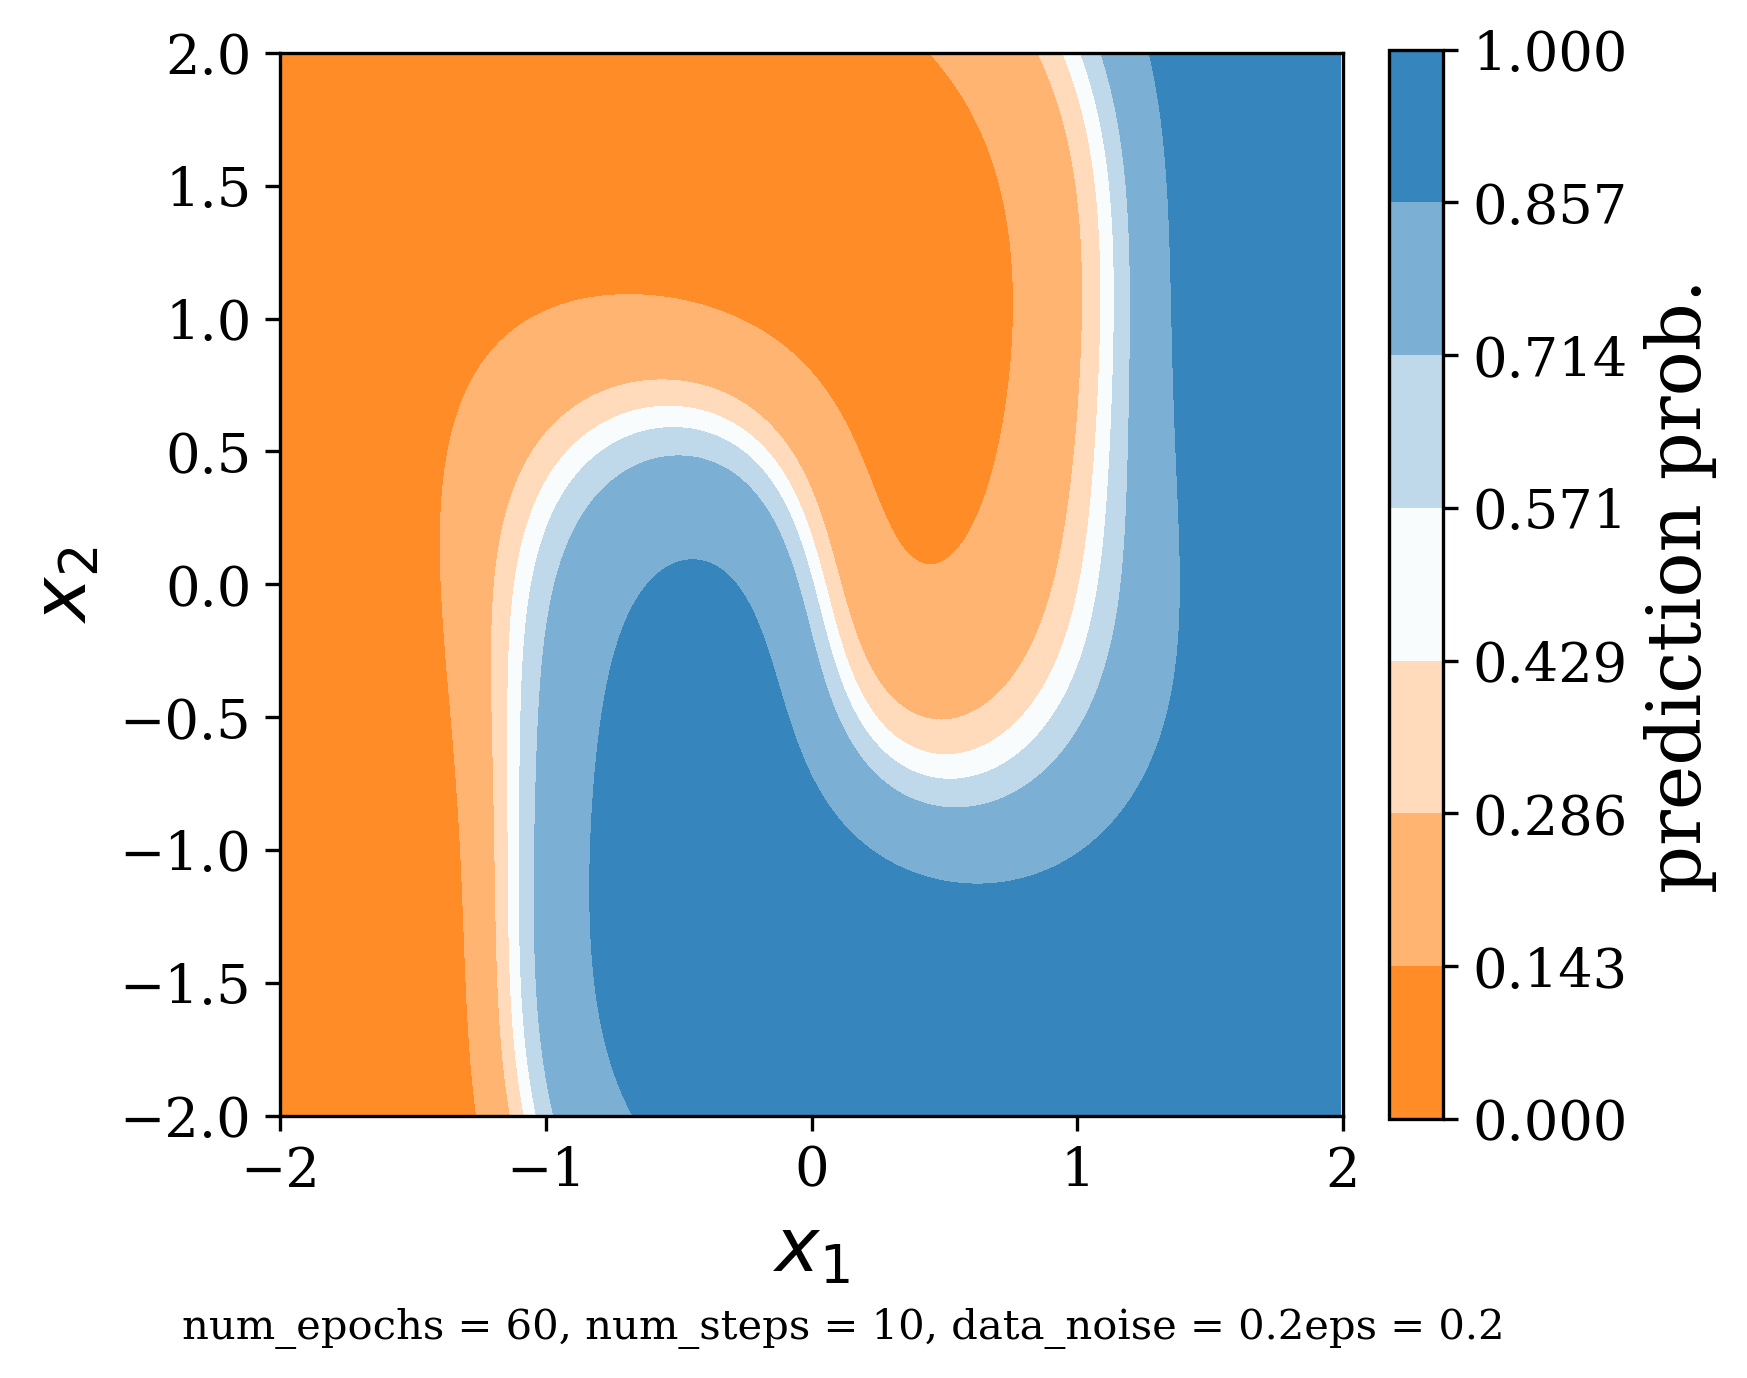

In [178]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base, footnote = footnote + ', eps = 0')
classification_levelsets(rnode, fig_name_base + '_rob', footnote = footnote + f'{eps = }')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)

display(img1,img2)

## Lyapunov exponent computation

In [179]:
# Define inputs
input1 = torch.tensor([1, 0], dtype=torch.float32)
input2 = torch.tensor([0, 1], dtype=torch.float32)
time_interval = torch.tensor([0, T], dtype=torch.float32)


def input_to_output(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    return node.flow(input, time_interval)[-1]

def LEs(input, node, time_interval = torch.tensor([0, T], dtype=torch.float32)):
    #fix the node so it is just a input to output of the other variable
    input_to_output_lambda = lambda input: input_to_output(input, node, time_interval)
    # Compute the Jacobian matrix
    J = torch.autograd.functional.jacobian(input_to_output_lambda, input)
    
    # Perform Singular Value Decomposition
    U, S, V = torch.svd(J)
    
    # Return the maximum singular value
    return 1/time_interval[1] * np.log(S)

# def LEs(singular_values,T):
#     return 1/T * np.log(singular_values)
    

def input_to_output_elena(input):
    return anode.flow.dynamics.forward(T-1,input)


les = LEs(input1, anode)
print(les)


tensor([ 0.3497, -0.4553], grad_fn=<TanhBackward>)
tensor([ 0.3063, -0.4570])


# Plot ANODE

In [189]:
def LE_grid(node, x_amount = 100, time_interval = torch.tensor([0, T], dtype=torch.float32)):
        
        x = torch.linspace(-2,2,x_amount)
        y = torch.linspace(-2,2,x_amount)
        X, Y = torch.meshgrid(x, y)

        inputs = torch.stack([X,Y], dim=-1)
        inputs = inputs.view(-1,2) #to be able to loop through all the grid values
        inputs_MLE_max = torch.zeros(x_amount * x_amount)
        inputs_MLE_min = torch.zeros(x_amount * x_amount)



        for i, input in enumerate(inputs):
                
                inputs_MLE_max[i] = torch.max(LEs(input, node, time_interval))
                inputs_MLE_min[i] = torch.min(LEs(input, node, time_interval))
        
        
        output_max = inputs_MLE_max.view(x_amount,x_amount)
        output_min = inputs_MLE_min.view(x_amount,x_amount)
        
        return output_max, output_min

output_max, output_min = LE_grid(anode)

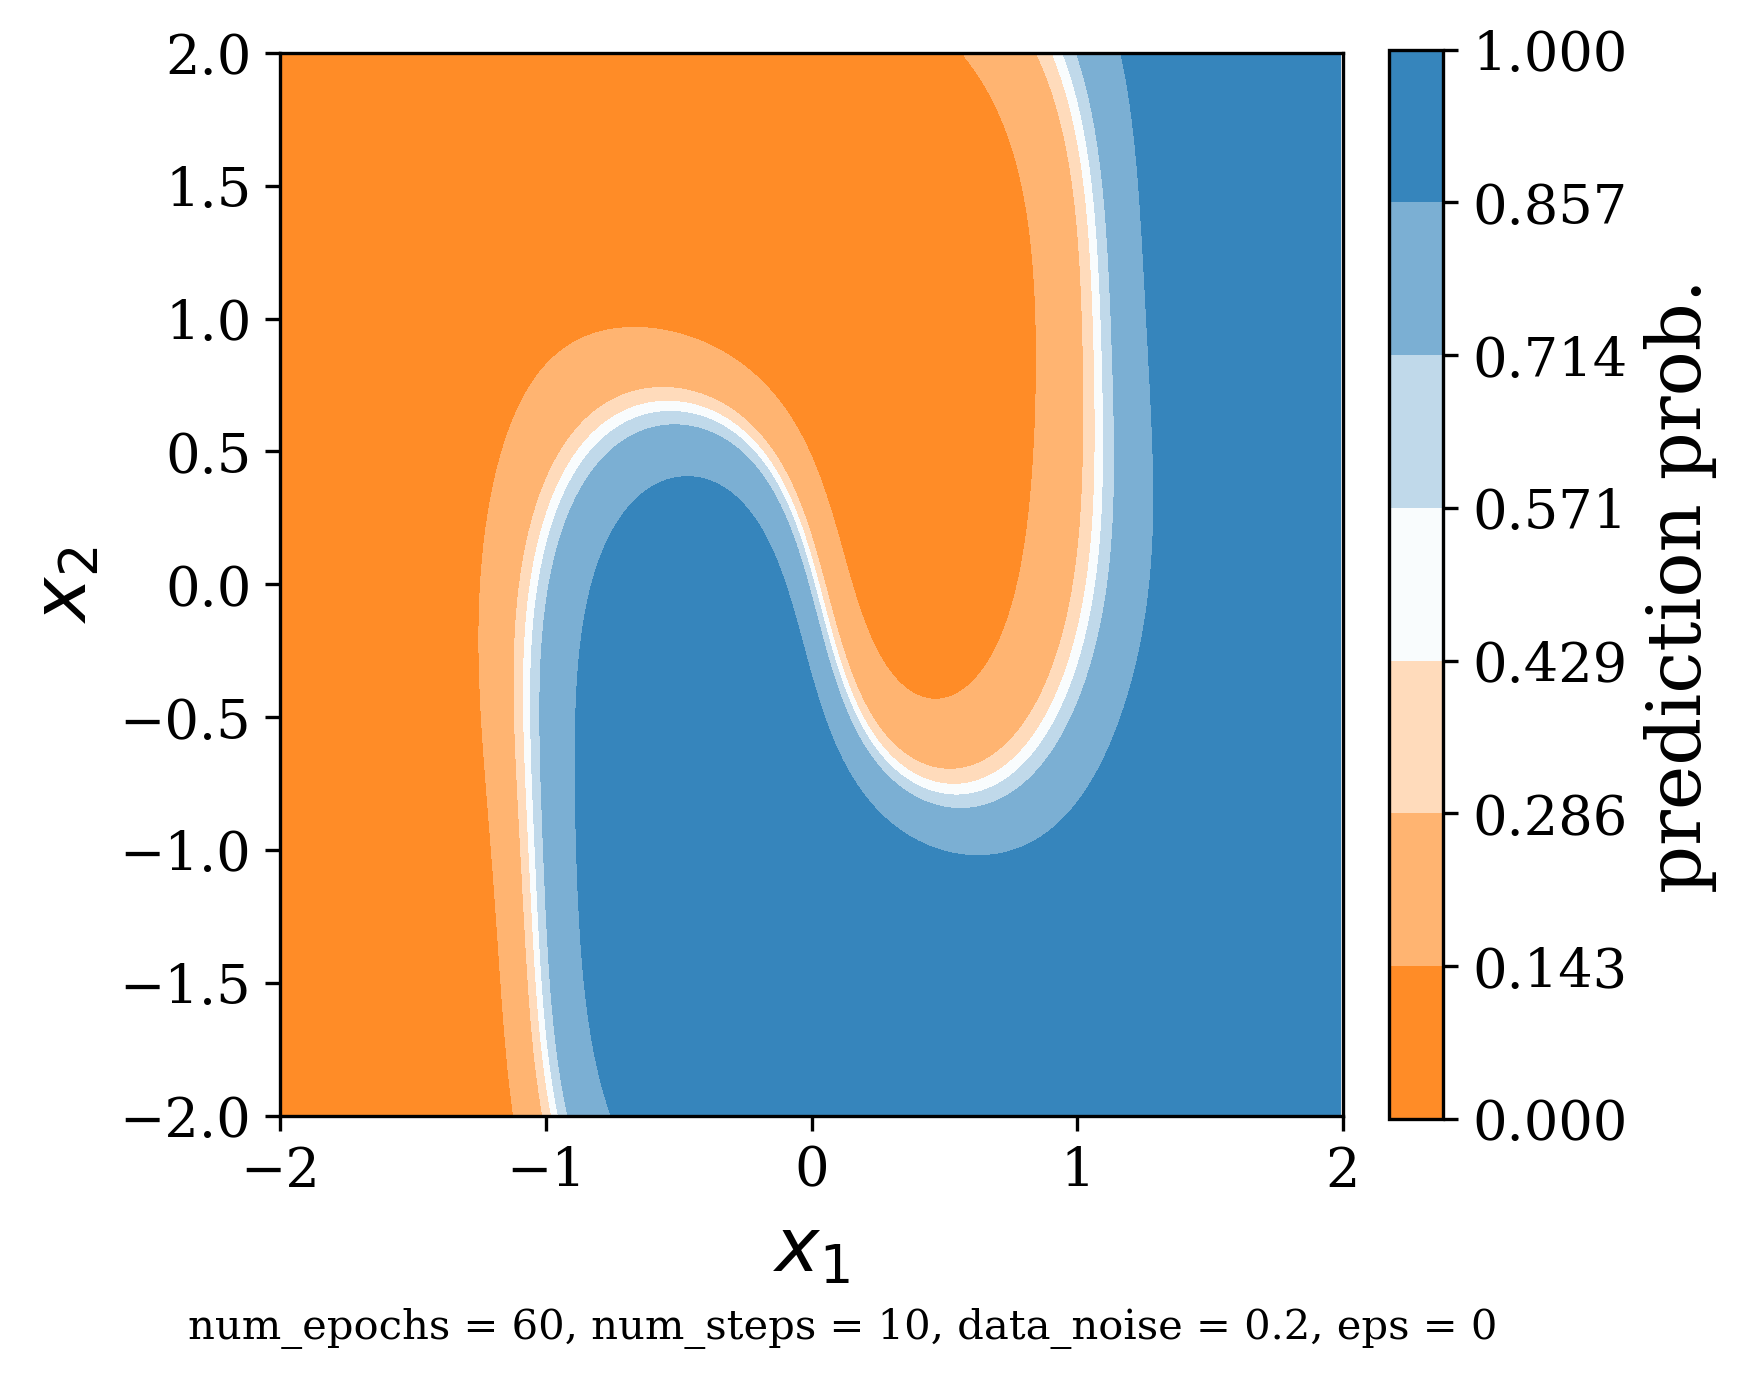

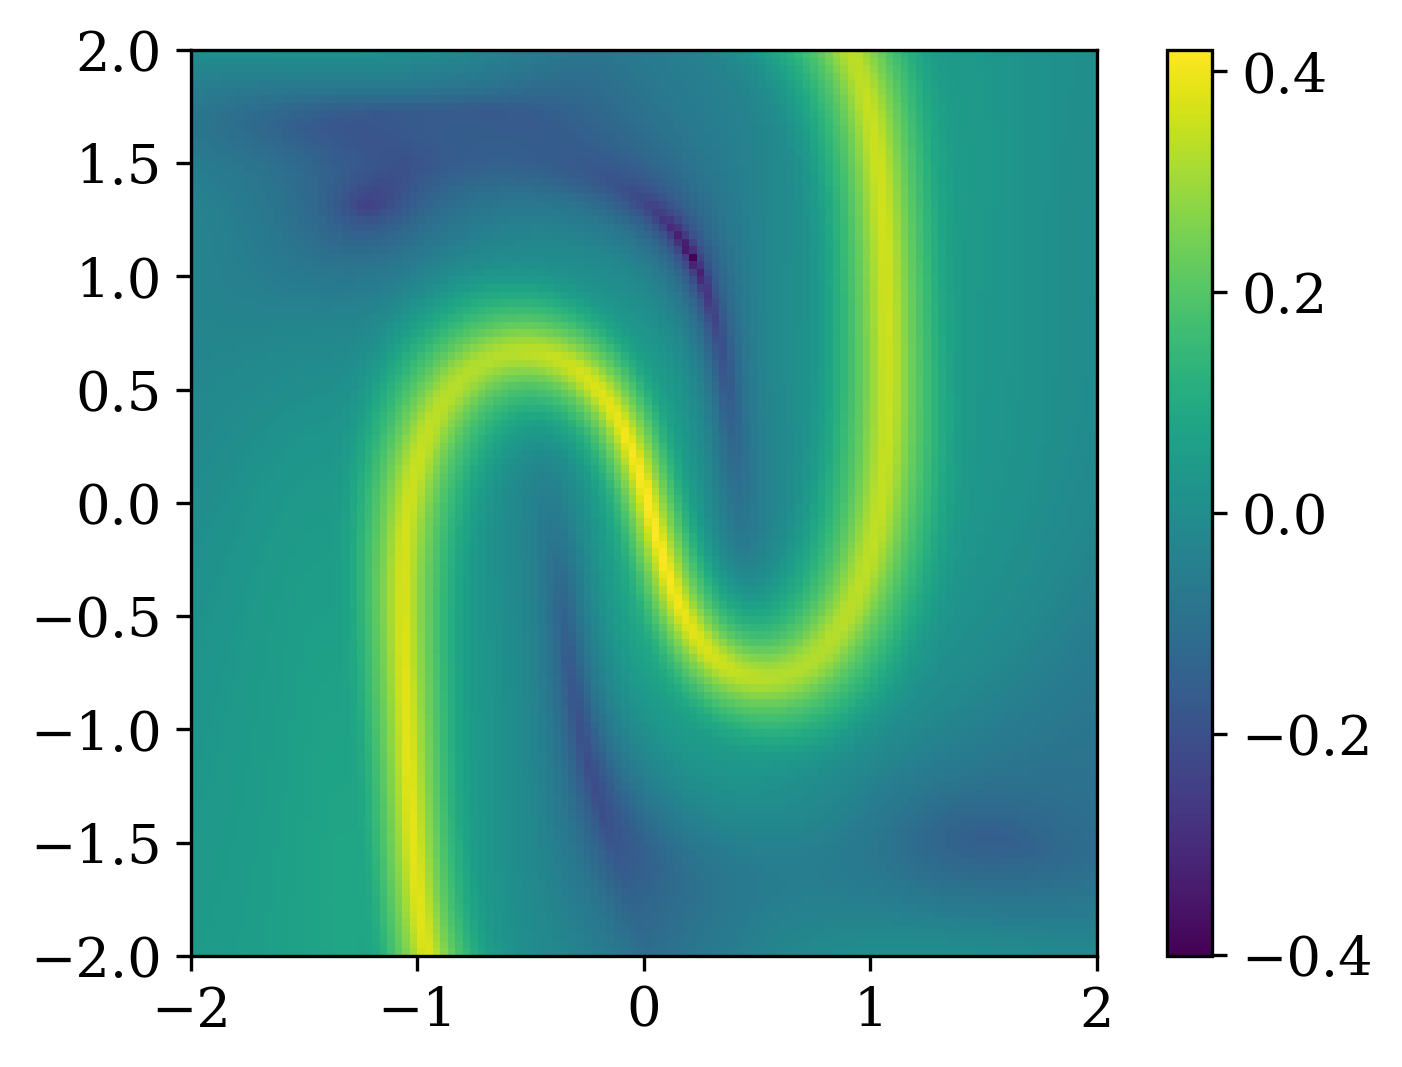

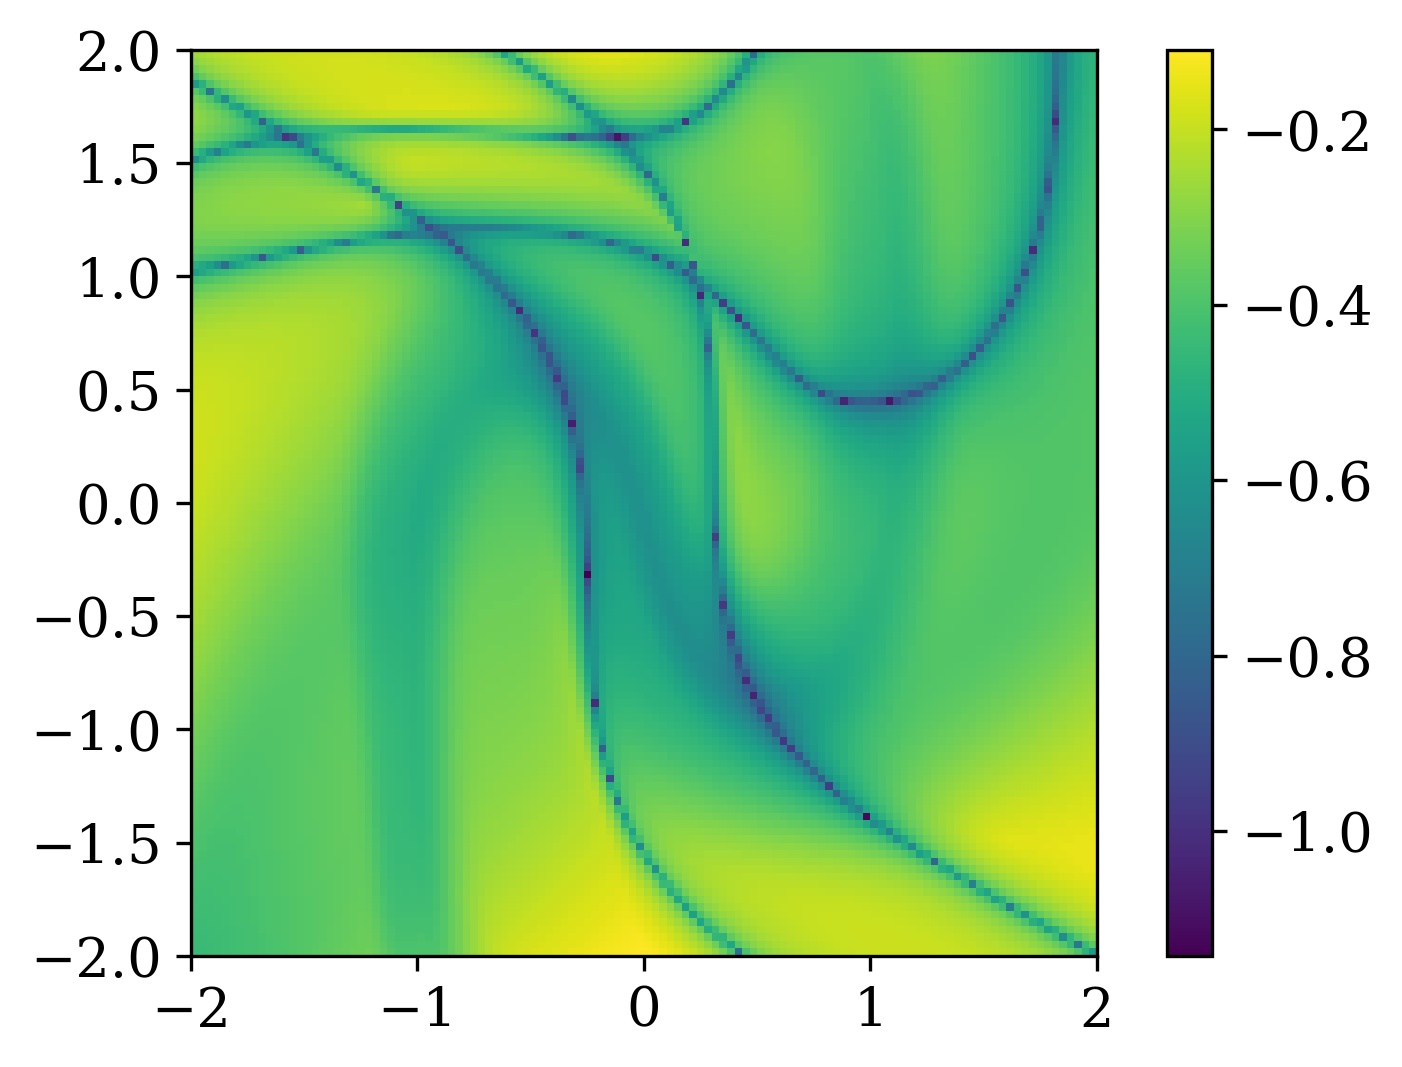

In [208]:


from matplotlib.colors import CenteredNorm, to_rgba, LinearSegmentedColormap

anodeimg_max = plt.imshow(np.rot90(output_max), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')
vmin_max, vmax_max = anodeimg_max.get_clim()

plt.colorbar()  # Show color scale
plt.savefig('MLE_max.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

anodeimg_min = plt.imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')#, norm=CenteredNorm(vcenter=0)) # cmap='viridis')
vmin_min, vmax_min = anodeimg_min.get_clim()

plt.colorbar()  # Show color scale
plt.savefig('MLE_min.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE_max.png', width = 400)
img3 = Image(filename = 'MLE_min.png', width = 400)

display(img1,img2,img3)

Evolution of the Finite Time Lyapunov Exponents over the whole interval

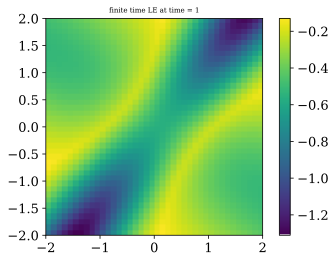

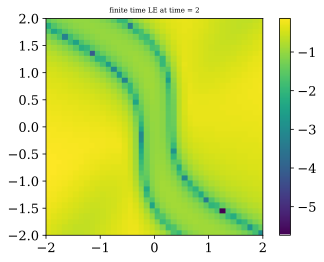

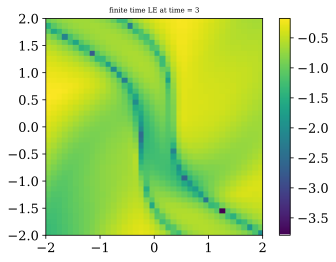

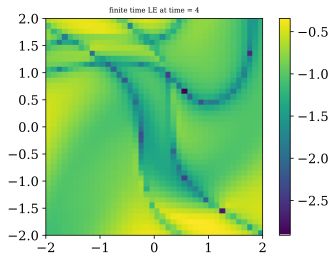

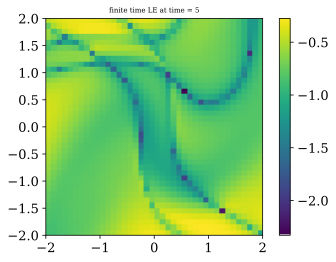

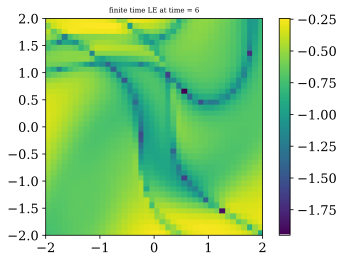

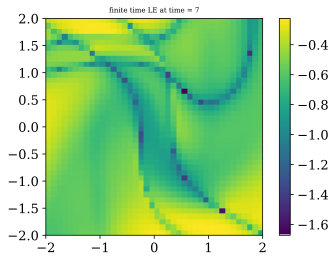

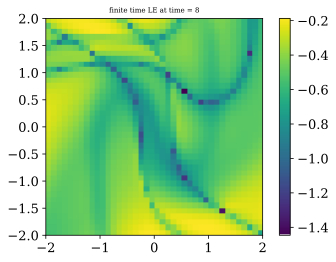

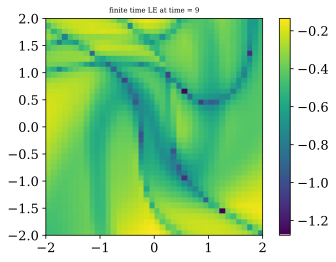

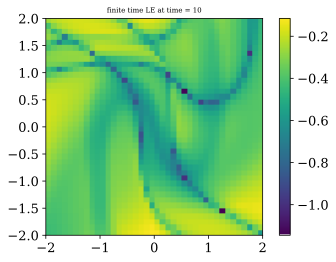

In [203]:
x_amount = 40

for T in range(1,11):
    time_interval = torch.tensor([0, T], dtype=torch.float32)

    output_max, output_min = LE_grid(anode, x_amount, time_interval)

    # plt.imshow(np.rot90(output_max), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')

    # plt.colorbar()  # Show color scale
    # plt.show()

    plt.imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')#, norm=CenteredNorm(vcenter=0)) # cmap='viridis')
    plt.colorbar()  # Show color scale
    plt.title(f'finite time LE at time = {T}', fontsize = 7)
    plt.show()

In [211]:
import imageio
import os

# Directory to save images
image_dir = 'gif_images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    
x_amount = 100


# Generate and save plots
for T in range(1, 11):
    time_interval = torch.tensor([0, T], dtype=torch.float32)
    
    output_max, output_min = LE_grid(anode, x_amount, time_interval)
    
    plt.imshow(np.rot90(output_min), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
    plt.clim(vmin_min,vmax_min)
    plt.colorbar()  # Show color scale
    plt.title(f'finite time LE for interval = [0, {T}]', fontsize=7)
    
    # Save the figure
    filename = os.path.join(image_dir, f'plot_{T}.png')
    plt.savefig(filename, bbox_inches='tight', dpi=100, format='png', facecolor='white')
    plt.close()

# Create GIF
images = []
for T in range(1, 11):
    filename = os.path.join(image_dir, f'plot_{T}.png')
    images.append(imageio.imread(filename))

imageio.mimsave('finite_time_LE.gif', images, fps=1)

# Clean up (optional)
for T in range(1, 11):
    os.remove(os.path.join(image_dir, f'plot_{T}.png'))
os.rmdir(image_dir)

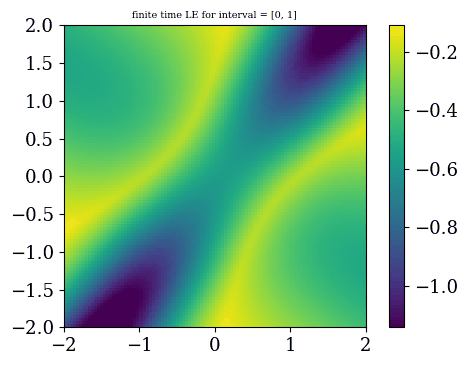

In [212]:
LEevo = Image(filename="finite_time_LE.gif")
display(LEevo)

In [182]:
# Find the 5 smallest values in inputs_MLE_min
amount_lowest = 1
amount_pert = 4
distance = torch.tensor(2 * np.pi / amount_pert)
eps = 0.05
_, indices = torch.topk(inputs_MLE_min, amount_lowest, largest=False)

# Convert indices to coordinates and create a tensor
coordinates = inputs[indices]
print(coordinates)
pert_tensor = torch.zeros_like(inputs[0:amount_lowest*(amount_pert)])


for input in coordinates:
    for j in range(amount_pert):
        x1 = torch.sin(j * distance)
        x2 = torch.cos(j * distance)
        
        pert = eps * torch.tensor([x1, x2])
        pert_tensor[j] = input + pert

# Output the tensor of the 5 coordinates
print(pert_tensor)

coordinates = torch.cat([coordinates, pert_tensor])
print(coordinates)

tensor([[ 0.3838, -0.5859]])
tensor([[ 0.3838, -0.5359],
        [ 0.4338, -0.5859],
        [ 0.3838, -0.6359],
        [ 0.3338, -0.5859]])
tensor([[ 0.3838, -0.5859],
        [ 0.3838, -0.5359],
        [ 0.4338, -0.5859],
        [ 0.3838, -0.6359],
        [ 0.3338, -0.5859]])


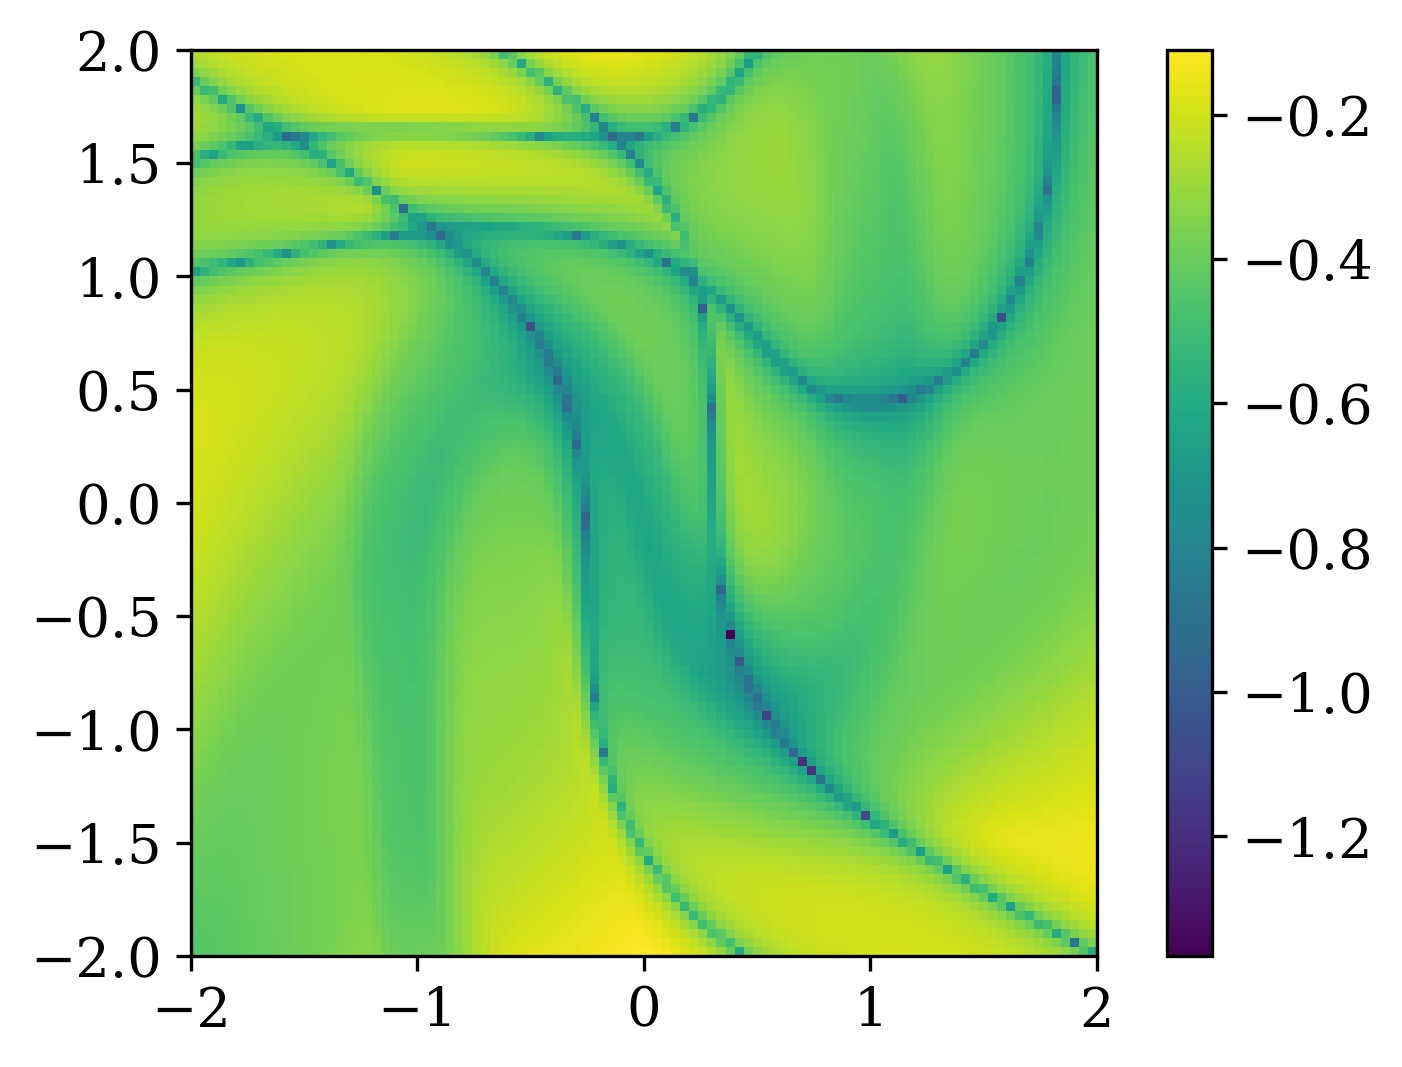

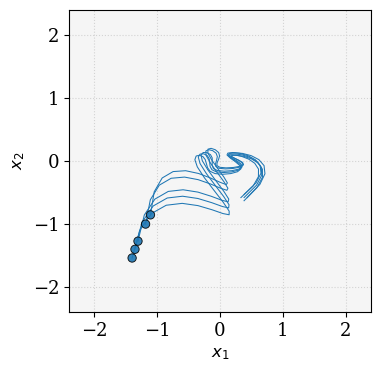

In [183]:
y_viz = torch.zeros([amount_lowest*(amount_pert+1)])
trajectory_gif(anode, coordinates, y_viz[0:amount_lowest*(amount_pert+1)], timesteps=num_steps, filename = 'trajectory_low.gif', axlim = 2, dpi = 100) #labels currently wrong!

#Display of the generated gif
traj = Image(filename="trajectory_low.gif")
traj_end = Image(filename="trajectory_low39.png")
display(img3,traj_end)

# PLOT RNODE

In [184]:

x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)

inputs = torch.stack([X,Y], dim=-1)
inputs = inputs.view(-1,2) #to be able to loop through all the grid values
inputs_MLE_max = torch.zeros(x_amount * x_amount)
inputs_MLE_min = torch.zeros(x_amount * x_amount)



for i, input in enumerate(inputs):
        
        inputs_MLE_max[i] = torch.max(LEs(input, rnode, time_interval))
        inputs_MLE_min[i] = torch.min(LEs(input, rnode, time_interval))
        

routput_max = inputs_MLE_max.view(x_amount,x_amount)
routput_min = inputs_MLE_min.view(x_amount,x_amount)


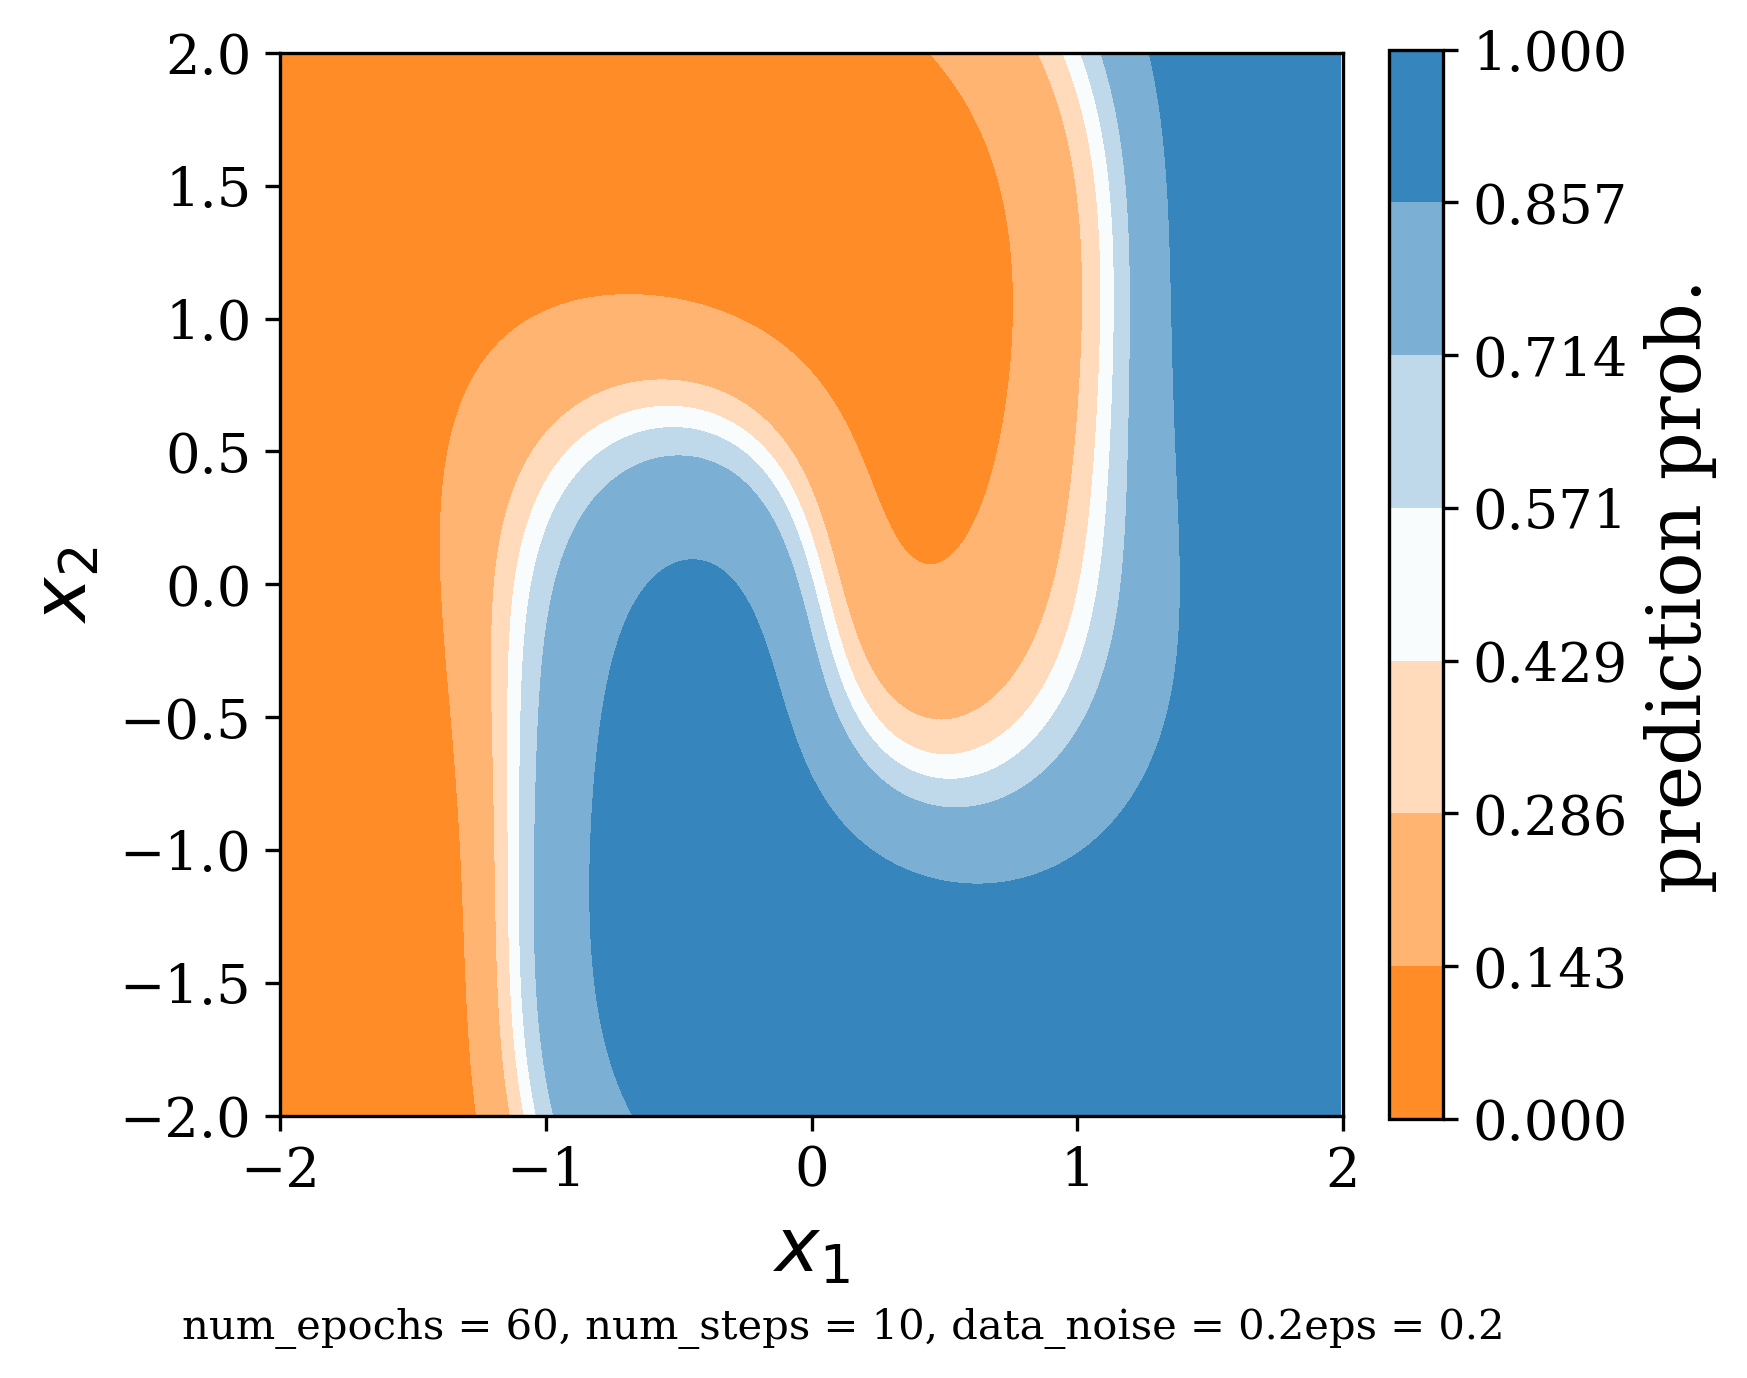

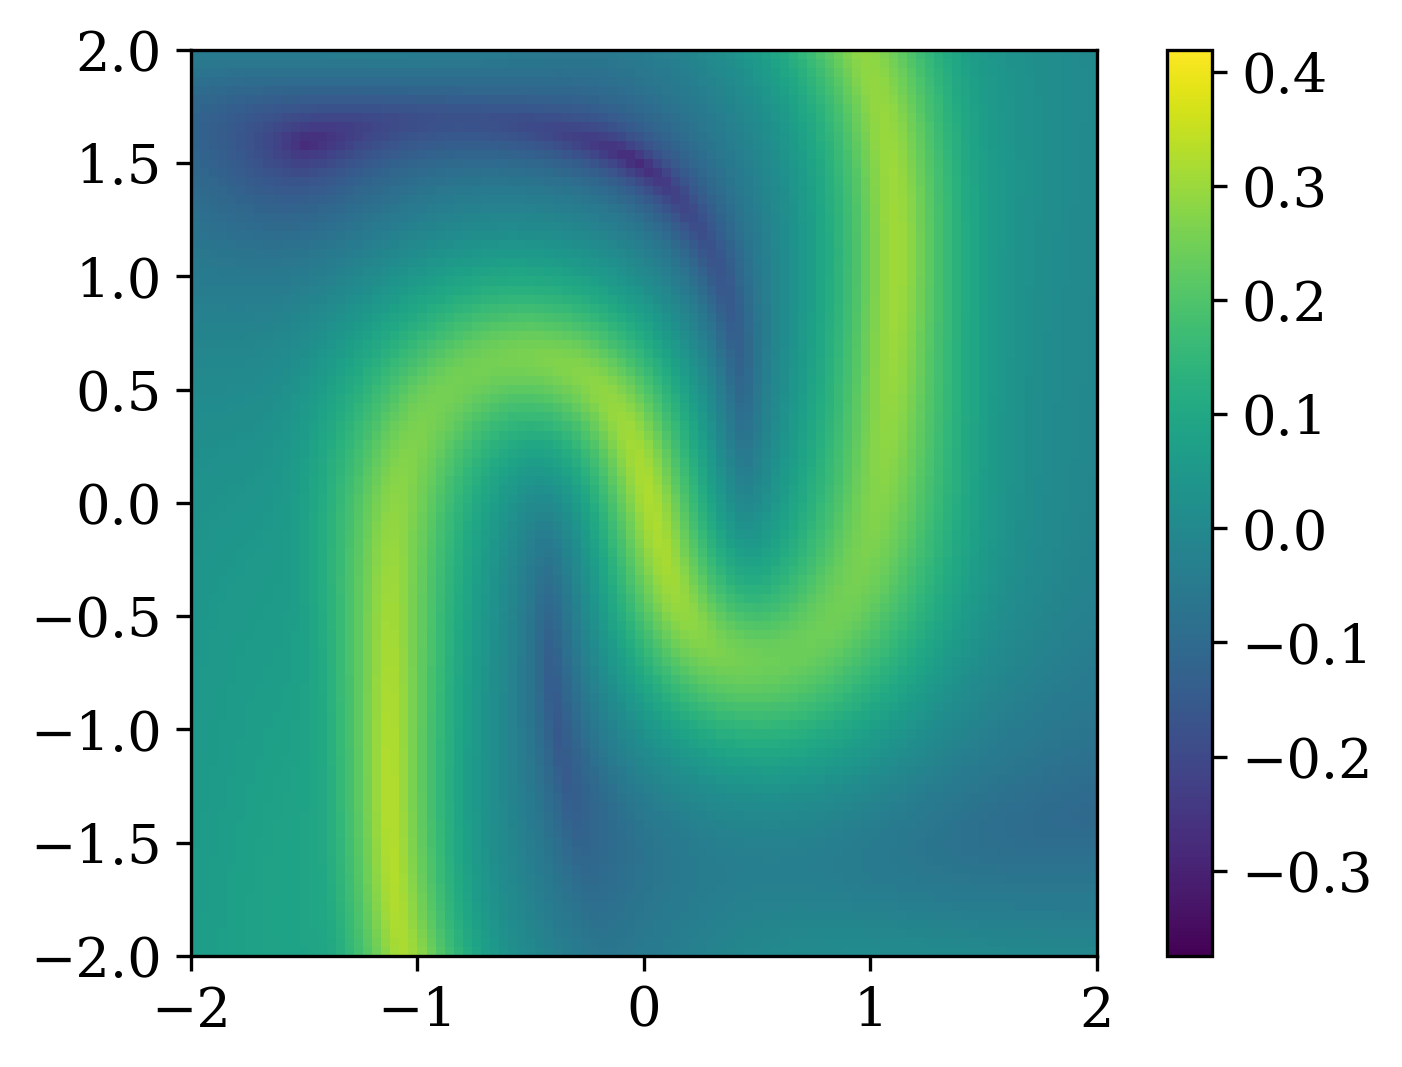

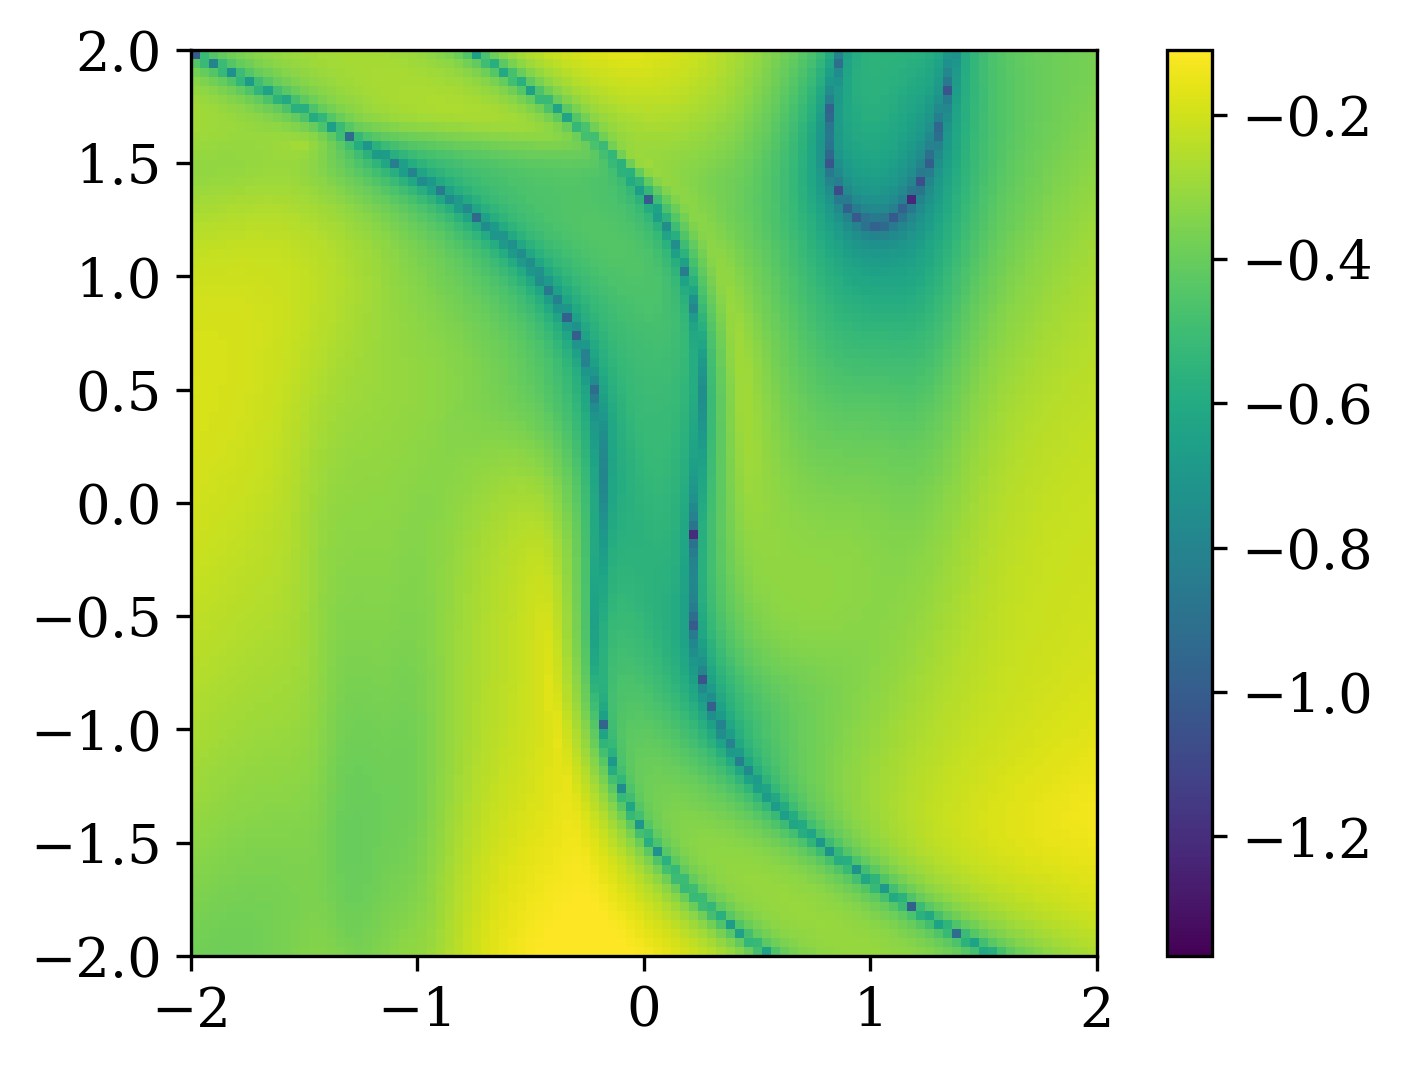

In [185]:
# Create heatmap using imshow

plt.imshow(np.rot90(routput_max), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
plt.clim(vmin_max,vmax_max)
plt.colorbar()  # Show color scale
plt.savefig('MLE_rob_max.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

plt.imshow(np.rot90(routput_min), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
plt.clim(vmin_min,vmax_min)
plt.colorbar()  # Show color scale
plt.savefig('MLE_rob_min.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '_rob' + '.png', width = 400)
img2 = Image(filename = 'MLE_rob_max.png', width = 400)
img3 = Image(filename = 'MLE_rob_min.png', width = 400)

display(img1,img2,img3)

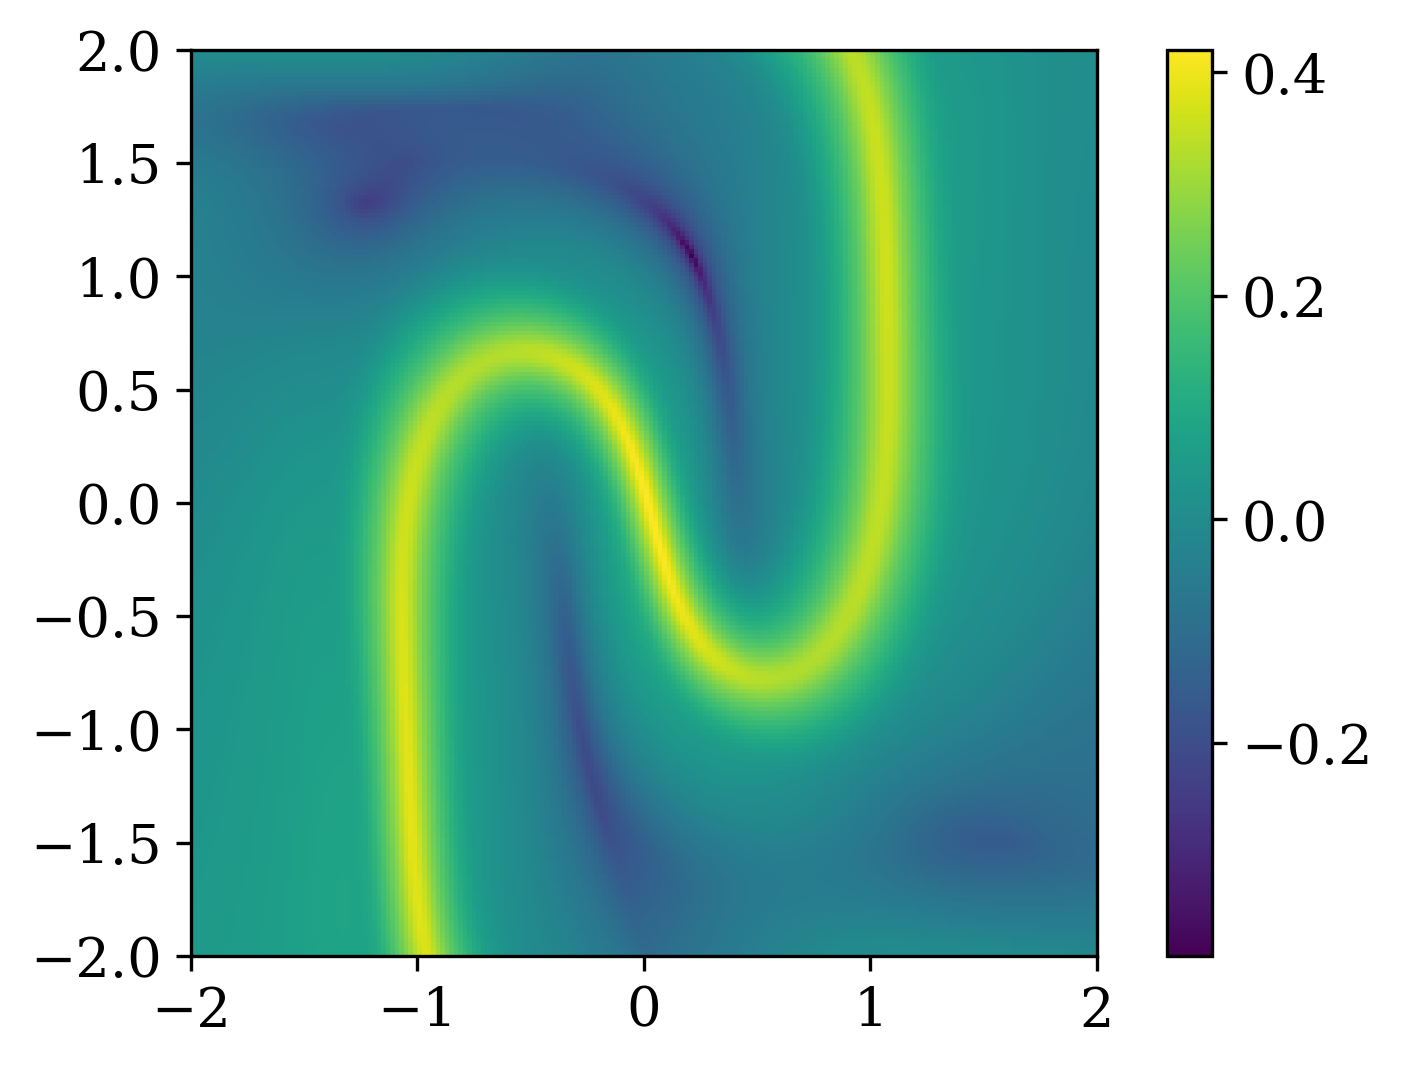

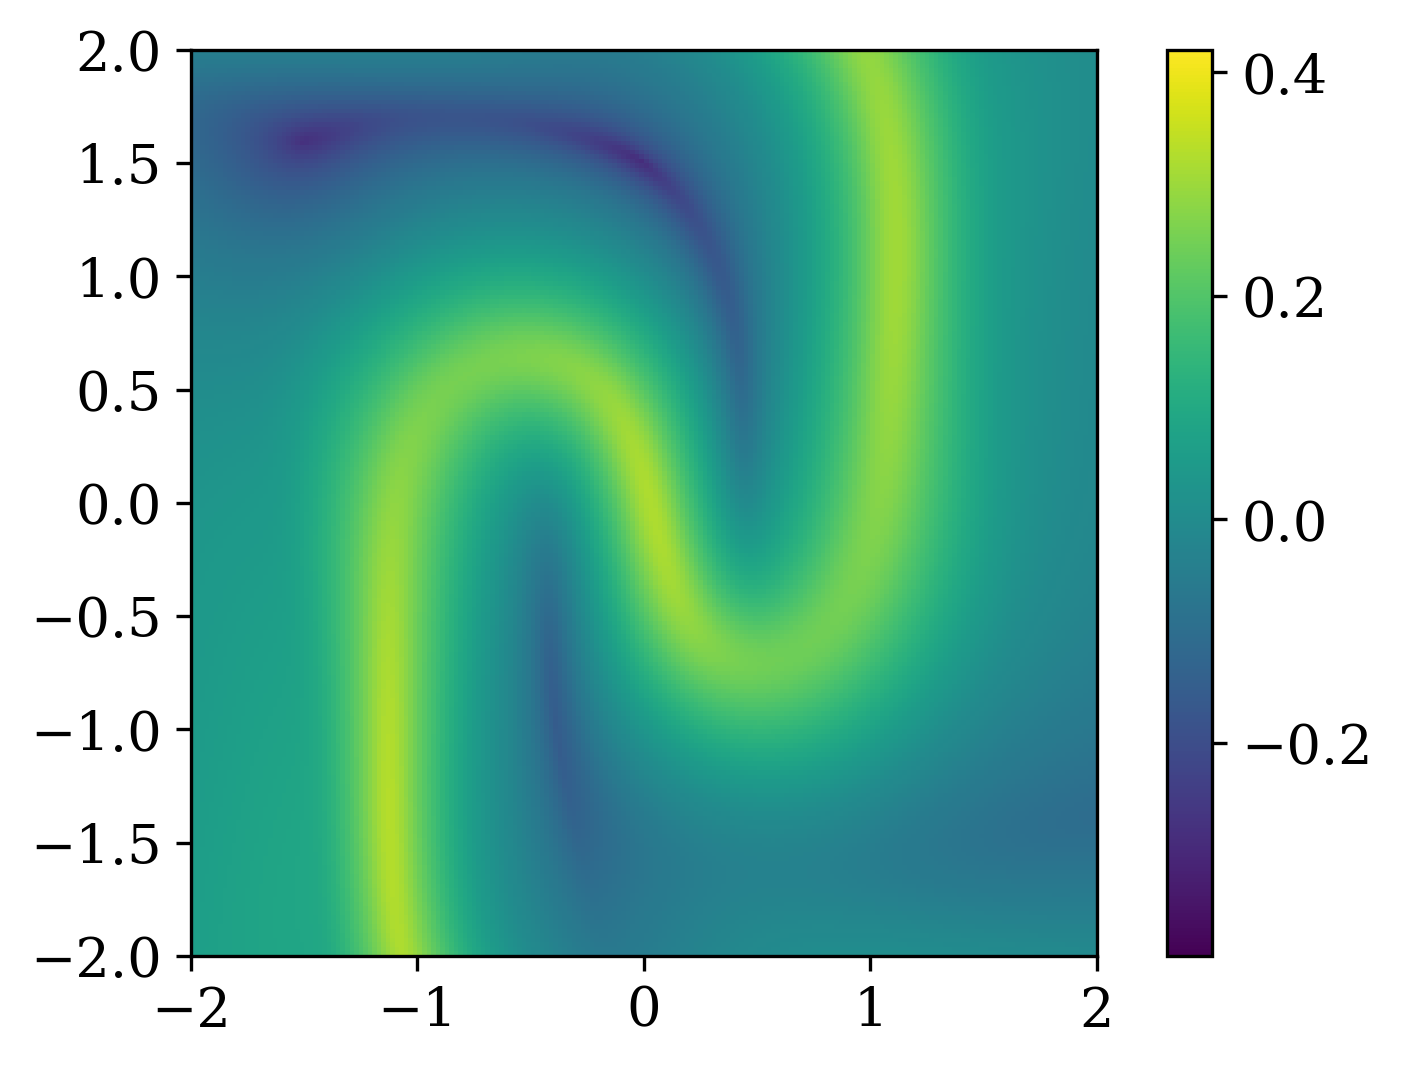

In [108]:
# img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE.png', width = 400)
# img3 = Image(filename = fig_name_base + '_rob' + '.png', width = 400)
img4 = Image(filename = 'MLE_rob.png', width = 400)

display(img2,img4)

ValueError: cannot reshape array of size 40000 into shape (100,100)

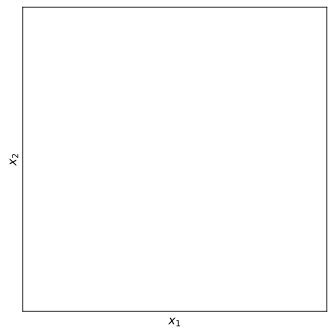

In [109]:
from matplotlib.ticker import FuncFormatter

def MLE_test(output, x, y, fig_name=None, footnote=None, contour = True, plotlim = [-1, 1], filename = None):
    
    
    fig = plt.figure(figsize=(5, 5), dpi=100)


    x1lower, x1upper = -2, 2
    x2lower, x2upper = -2, 2

    # model_inputs = torch.stack([x, y], dim=-1)



    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
   
    
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()



    z = np.array(output).reshape(x.shape)

    levels = np.linspace(vmin-0.01,vmax,80).tolist()

    cont = plt.contourf(x, y, z, levels, alpha=1, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
    cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('First Lyapunov Exponent')
    
        # Define a custom formatting function for two decimal places
    def two_decimal_format(x, pos):
        return f'{x:.2f}'

    # Apply the custom formatter to the colorbar
    cbar.formatter = FuncFormatter(two_decimal_format)
    cbar.update_ticks()

    if filename:
        plt.savefig(filename + '.png',bbox_inches='tight', dpi=400, format='png', facecolor = 'white')
        plt.close()

x_amount = 100 
x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)  
    
MLE_test(output, X, Y, filename = 'LE')
MLE_test(routput, X, Y, filename = 'robust_LE')


img_a = Image(filename = 'LE.png', width = 400)
img_b = Image(filename = 'robust_LE.png', width = 400)

display(img_a,img_b)


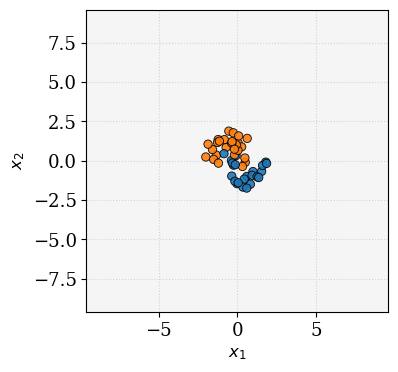

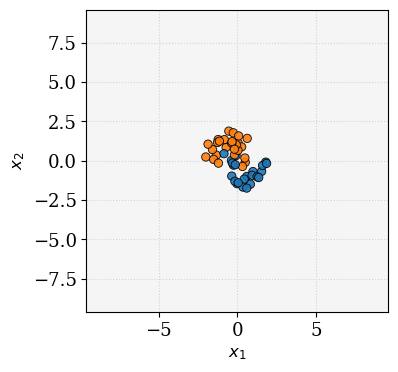

In [87]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

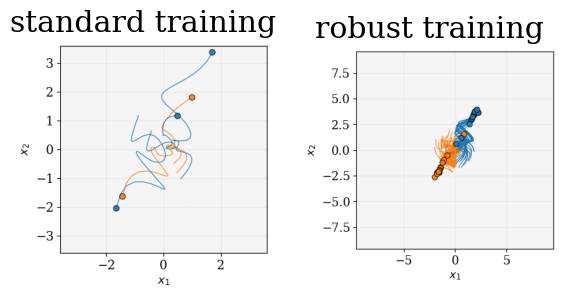

In [74]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory39.png", 'standard training', "trajectory_db39.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [89]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()
        

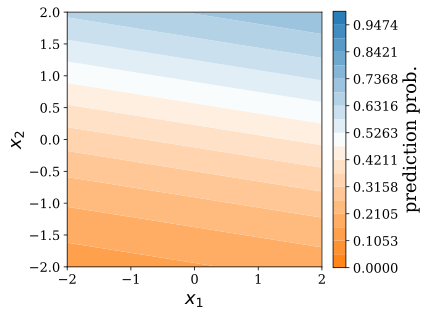

In [90]:
linlayer_levelsets(anode)

In [91]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, fps = 2)